### Import Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [4]:
data=pd.read_csv('datasets/tweets.csv')

### Check for null values

In [5]:
data.isnull().sum()

tweets    0
labels    0
dtype: int64

In [6]:
#get stopword list
sw_list=stopwords.words('english')

### Since it might affect final outcome, a few words are removed from stopwords list

In [7]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->True
No------>True
Against->True


In [8]:
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [9]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->False
No------>False
Against->False


In [10]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Function to clean tweets

In [11]:
#Get nltk tag for lemmatizing a given token
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [12]:
# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)
    

In [13]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()


In [14]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Checking and Discarding tweets left empty after cleaning (tweets that contained only retweets, pings and URLs)

In [15]:
data[data['tweets']=='']

,tweets,labels
446,,0
905,,0
1067,,0
1082,,0
1093,,0
1101,,0
1290,,0


In [16]:
len(data)

1364

In [17]:
data.eq('').sum()

tweets    7
labels    0
dtype: int64

In [18]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

In [19]:
len(data)

1357

### Train-Test split

In [20]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [21]:
lengths=pd.DataFrame(len(tweet.split(' ')) for tweet in X_train)

In [22]:
test_length=pd.DataFrame(len(tweet.split(' ')) for tweet in X_test)

In [23]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

### TF-IDF Vectorization

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

### Combined dataframe of training data

In [25]:
train_data=pd.concat((X_train,y_train),axis=1,ignore_index=True)
train_data.columns=['tweets','labels']
train_data.reset_index(inplace=True,drop=True)
train_data=pd.concat((train_data,X_train_tfidf),axis=1)
train_data

,tweets,labels,0,1,2,3,4,5,6,7,...,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467
0,obama admin cry tax increase applaud china low...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,barack obama longboard package core truck mm b...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,edshow whenever obama tell truth gop boo hoo h...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,many foreign leader obama promise post electio...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,obama signal us would accept iranian civilian ...,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.254869,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,mean saving scotus tell world obama wrong aca ...,0,0.0,0.0,0.0,0.0,0.0,0.335548,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1081,obama sharpen kansas vision,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1082,genius man sing else really obama,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,mitt romney obama spend much time harvard also...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combined dataframe of test data

In [26]:
test_data=pd.concat((X_test,y_test),axis=1,ignore_index=True)
test_data.columns=['tweets','labels']
test_data.reset_index(inplace=True,drop=True)
test_data=pd.concat((test_data,X_test_tfidf),axis=1)
test_data

,tweets,labels,0,1,2,3,4,5,6,7,...,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467
0,harry style describe michelle obama como una m...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,amp si khady president obama get elect nyrell ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,obama black american really need time whitey f...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,whatsromneyhiding throw baseball like man not ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,realclearpolitics obama organizational advanta...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,romney attack obama barnstorm pennsylvania,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,obama thug bully not sure call rush limbaugh bill,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,michelle barack obama become like celebrity ta...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,whatsromneyhiding nothing compare mt proof oba...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.310191,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
y_train.shape

(1085,)

### Convert y_train and y_test to multi-class categorical format

In [28]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

### Create Tensorboard Callback

In [29]:
from tensorflow.keras.callbacks import TensorBoard

In [30]:
log_directory = 'logs-tfidf-LSTM\\fit'

board_3 = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True)

### Reshape X_train and X_test into 3-Dimensional Data
#### LSTM requires 3 Dimensional input in the form (samples, timesteps, features)

In [31]:
X_train_tfidf=X_train_tfidf.values.reshape(X_train_tfidf.shape[0],1,X_train_tfidf.shape[1])

In [32]:
X_test_tfidf=X_test_tfidf.values.reshape(X_test_tfidf.shape[0],1,X_test_tfidf.shape[1])

### Create and train model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,LSTM

In [34]:
model_3=Sequential()
model_3.add(LSTM(units=50))
model_3.add(Dropout(0.2))
model_3.add(Dense(activation='softmax',units=3))
model_3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
#Setting test data as validation data to see how the model performs on the test data over training period
history_3=model_3.fit(x=X_train_tfidf,y=y_train,epochs=20,callbacks=[board_3],validation_data=(X_test_tfidf,y_test))

Epoch 1/20
 1/34 [..............................] - ETA: 0s - loss: 1.1000 - accuracy: 0.3125WARNING:tensorflow:From C:\Users\varun\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
34/34 [==============================] - 2s 52ms/step - loss: 1.0356 - accuracy: 0.6682 - val_loss: 0.9725 - val_accuracy: 0.6691
Epoch 2/20
34/34 [==============================] - 1s 15ms/step - loss: 0.9077 - accuracy: 0.6839 - val_loss: 0.8549 - val_accuracy: 0.6691
Epoch 3/20
34/34 [==============================] - 0s 14ms/step - loss: 0.7900 - accuracy: 0.6839 - val_loss: 0.7615 - val_accuracy: 0.6691
Epoch 4/20
34/34 [==============================] - 0s 10ms/step - loss: 0.7010 - accuracy: 0.6848 - val_loss: 0.6988 - val_accuracy: 0.6691
Epoch 5/20
34/34 [==============================] - 0s 10ms/

### Model Evaluation

In [36]:
y_predictions=(model_3.predict(X_test_tfidf) > 0.5).astype("int32")

### Check accuracy and other metrics

In [37]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       182
           1       0.85      0.72      0.78        78
           2       1.00      0.33      0.50        12

   micro avg       0.86      0.86      0.86       272
   macro avg       0.90      0.67      0.73       272
weighted avg       0.87      0.86      0.85       272
 samples avg       0.86      0.86      0.86       272



In [38]:
print(accuracy_score(y_test,y_predictions))

0.8566176470588235


In [39]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[174,   8,   0],
       [ 22,  56,   0],
       [  6,   2,   4]], dtype=int64)

<AxesSubplot:>

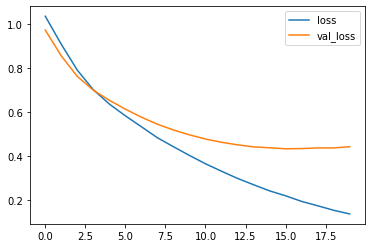

In [41]:
losses=pd.DataFrame(history_3.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

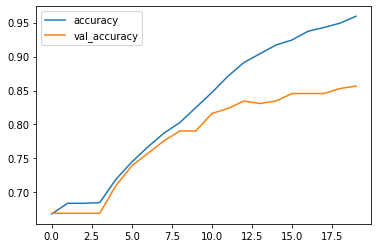

In [42]:
losses[['accuracy','val_accuracy']].plot()